In [1]:
!pip install numpy pandas matplotlib opencv-python tensorflow

In [2]:
# Install the Kaggle API
!pip install kaggle

In [3]:
# Upload the Kaggle API token
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# Move the uploaded file to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the ASL dataset from Kaggle
!kaggle competitions download -c asl-signs

100% 37.3G/37.4G [05:44<00:00, 115MB/s]
100% 37.4G/37.4G [05:44<00:00, 116MB/s]


In [6]:
# Unzip the downloaded dataset
!unzip -q asl-signs.zip



In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow as tf
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical

In [3]:
# Read the CSV file
df = pd.read_csv('train.csv')

# Display basic information about the dataset
df

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [4]:
# Check for missing values
print(df.isnull().sum())

path              0
participant_id    0
sequence_id       0
sign              0
dtype: int64


In [5]:
# Load the sign index mapping from the JSON file
with open('sign_to_prediction_index_map.json', 'r') as f:
    sign_index_mapping = json.load(f)

In [6]:
# Convert the sign index mapping to a DataFrame
sign_index_df = pd.DataFrame(list(sign_index_mapping.items()), columns=['sign', 'sign_info'])

# Display basic information about the sign index DataFrame
sign_index_df.head()

,sign,sign_info
0,TV,0
1,after,1
2,airplane,2
3,all,3
4,alligator,4


In [7]:
# Merge the two DataFrames based on the 'sign' column
merged_df = pd.merge(df, sign_index_df, how='left', on='sign')

# Display basic information about the merged DataFrame
merged_df.head()

,path,participant_id,sequence_id,sign,sign_info
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


In [14]:
sample_fillede\['type'].unique()

array(['face', 'left_hand', 'pose', 'right_hand'], dtype=object)

In [16]:
sample['frame'].unique()

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int16)

In [17]:
# Assuming your DataFrame is named 'train_df'
top_signs = df['sign'].value_counts().head(25)

# Display the top 25 sign words
print(top_signs)

listen        415
look          414
shhh          411
donkey        410
mouse         408
duck          405
hear          405
uncle         405
pretend       404
bird          404
cow           404
sleepy        403
brown         403
who           403
bye           402
nuts          402
fireman       402
lips          402
toothbrush    402
wake          401
awake         401
doll          400
cat           400
drink         400
pen           399
Name: sign, dtype: int64


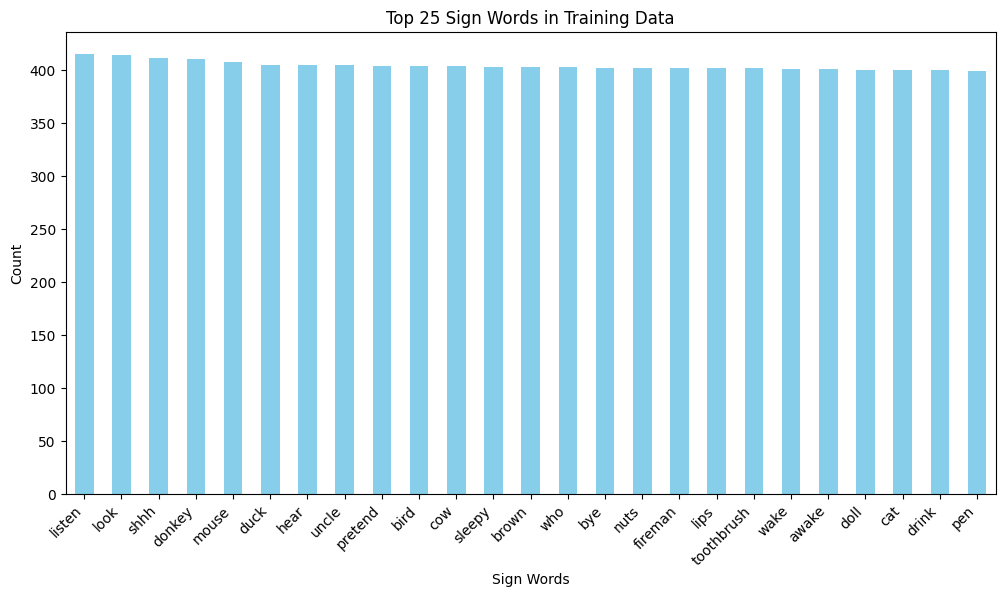

In [18]:
import matplotlib.pyplot as plt

# Plot the top 25 sign words
plt.figure(figsize=(12, 6))
top_signs.plot(kind='bar', color='skyblue')
plt.title('Top 25 Sign Words in Training Data')
plt.xlabel('Sign Words')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


In [11]:
#Read a Parquet file and set a sample
file_path = '/content/train_landmark_files/25571/1000210073.parquet'
landmark_sample = pd.read_parquet(file_path)

# Display the loaded data
landmark_sample

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.495870,0.478694,-0.037412
1,17,17-face-1,face,1,0.492222,0.447209,-0.067939
2,17,17-face-2,face,2,0.492067,0.457237,-0.035722
3,17,17-face-3,face,3,0.480419,0.415996,-0.050779
4,17,17-face-4,face,4,0.492035,0.437453,-0.072314
...,...,...,...,...,...,...,...
6511,28,28-right_hand-16,right_hand,16,0.506396,0.868416,-0.139545
6512,28,28-right_hand-17,right_hand,17,0.323227,0.835990,-0.136632
6513,28,28-right_hand-18,right_hand,18,0.435733,0.848917,-0.156200
6514,28,28-right_hand-19,right_hand,19,0.476093,0.867098,-0.149442


In [12]:
# Replace all NaN values with 0
sample = landmark_sample.fillna(0)

# Display the DataFrame with null values replaced
sample

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.495870,0.478694,-0.037412
1,17,17-face-1,face,1,0.492222,0.447209,-0.067939
2,17,17-face-2,face,2,0.492067,0.457237,-0.035722
3,17,17-face-3,face,3,0.480419,0.415996,-0.050779
4,17,17-face-4,face,4,0.492035,0.437453,-0.072314
...,...,...,...,...,...,...,...
6511,28,28-right_hand-16,right_hand,16,0.506396,0.868416,-0.139545
6512,28,28-right_hand-17,right_hand,17,0.323227,0.835990,-0.136632
6513,28,28-right_hand-18,right_hand,18,0.435733,0.848917,-0.156200
6514,28,28-right_hand-19,right_hand,19,0.476093,0.867098,-0.149442


<Figure size 1200x800 with 0 Axes>

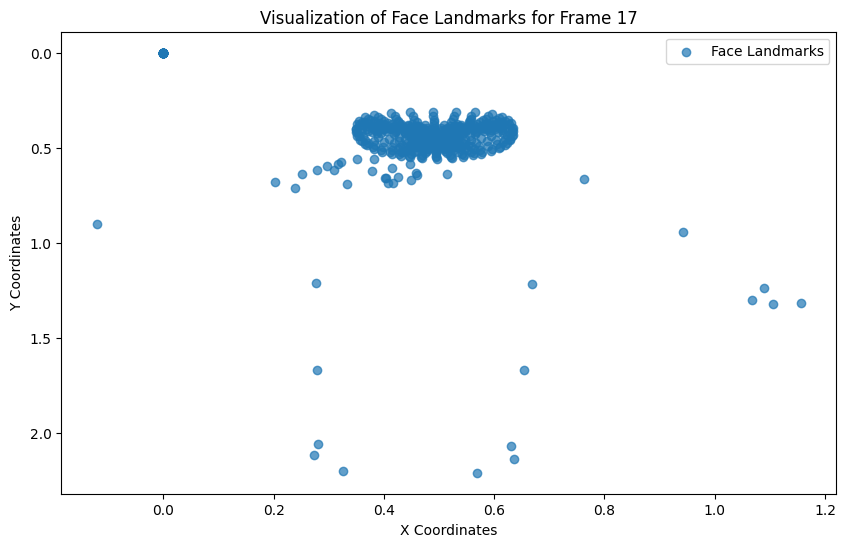

In [23]:
# Filter the DataFrame for a specific frame
frame_103_face = sample[(sample['frame'] == 17)]

# Plot each type of landmark separately
plt.figure(figsize=(12, 8))

# Scatter plot for 'face' landmarks with reversed y-axis
plt.figure(figsize=(10, 6))
plt.scatter(frame_103_face['x'], frame_103_face['y'], label='Face Landmarks', alpha=0.7)

# Reverse the y-axis
plt.gca().invert_yaxis()

# Set plot properties
plt.title('Visualization of Face Landmarks for Frame 17')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.legend()
plt.show()

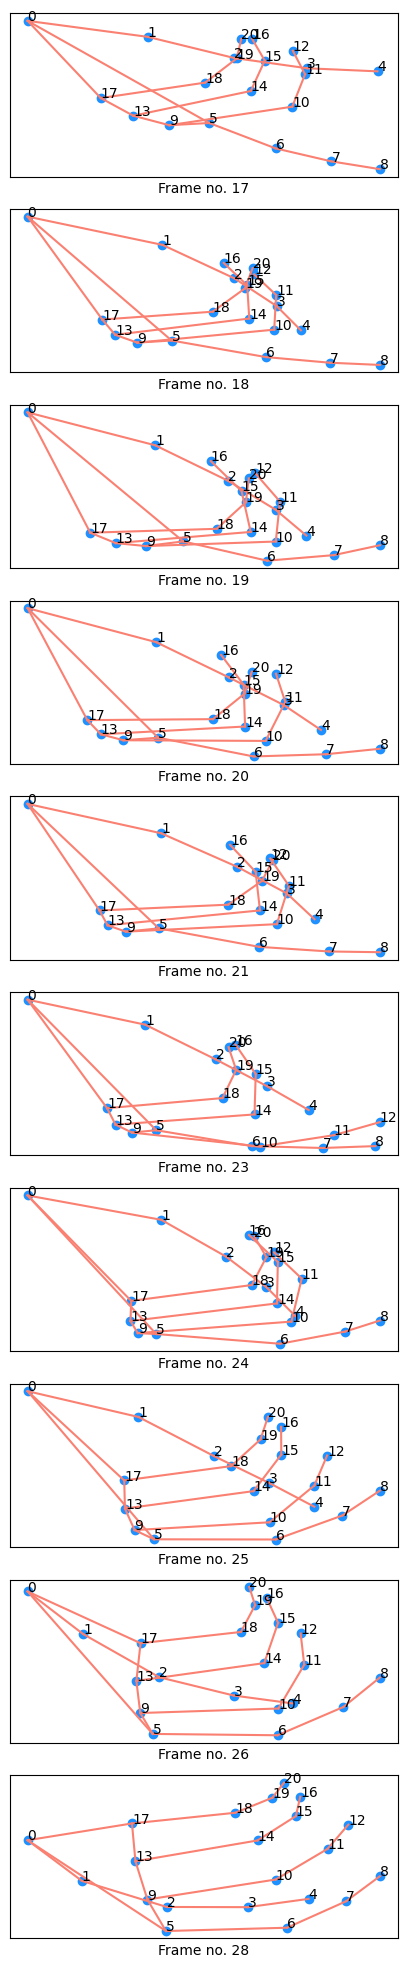

In [27]:
# pick the left hand and right hand points
sample_left_hand = sample[sample.type == "left_hand"]
sample_right_hand = sample[sample.type == "right_hand"]

# display(sample_left_hand)

# edges that represents the hand edges
# How he knows the edges, so a mystery
edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

# plotting a single frame into matplotlib
def plot_frame(df, frame_id, ax):
    df = df[df.frame == frame_id].sort_values(['landmark_index'])
    x = list(df.x)
    y = list(df.y)

    # plotting the points
    ax.scatter(df.x, df.y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], str(i))

    # plotting the edges that represents the hand
    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
        ax.set_xlabel(f"Frame no. {frame_id}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# plotting the multiple frames
def plot_frame_seq(df, frame_range, n_frames):
    frames = np.linspace(frame_range[0],frame_range[1],n_frames, dtype = int, endpoint=True)
    fig, ax = plt.subplots(n_frames, 1, figsize=(5,25))
    for i in range(n_frames):
        plot_frame(df, frames[i], ax[i])

    plt.show()

plot_frame_seq(sample_right_hand, (17,28), 10)

In [49]:
# Load landmark data (assuming you have a function to load Parquet files)
landmark_df = load_landmark_data('path/to/landmark_data.parquet')

KeyError: ignored

In [55]:
# Function to load landmark data from Parquet files in a folder
def load_landmark_data(folder_path):
    combined_meta = {}
    for root, dirs, files in os.walk(folder_path):
        for file_name in tqdm(files):
            if file_name.endswith(".parquet"):
                file_path = os.path.join(root, file_name)
                example_landmark = pd.read_parquet(file_path)

                # Replace null values with 0
                example_landmark.fillna(0, inplace=True)

                # Get the number of landmarks with x, y, z data per type
                meta = example_landmark.dropna(subset=["x", "y", "z"])["type"].value_counts().to_dict()
                meta["frames"] = example_landmark["frame"].nunique()

                # Calculate additional statistics if needed
                xyz_meta = (
                    example_landmark.agg(
                        {
                            "x": ["min", "max", "mean"],
                            "y": ["min", "max", "mean"],
                            "z": ["min", "max", "mean"],
                        }
                    )
                    .unstack()
                    .to_dict()
                )

                for key in xyz_meta.keys():
                    new_key = key[0] + "_" + key[1]
                    meta[new_key] = xyz_meta[key]

                combined_meta[file_path] = meta

    return combined_meta

# Specify the path to the root folder containing participant folders
root_folder_path = '/content/train_landmark_files'

# Load landmark data from all participant folders
combined_meta_all = {}
for participant_folder in tqdm(os.listdir(root_folder_path)):
    participant_folder_path = os.path.join(root_folder_path, participant_folder)

    if os.path.isdir(participant_folder_path):
        participant_combined_meta = load_landmark_data(participant_folder_path)
        combined_meta_all.update(participant_combined_meta)

# Create a DataFrame from the combined metadata
metadata_df = pd.DataFrame.from_dict(combined_meta_all, orient='index').reset_index()
metadata_df.rename(columns={'index': 'file_path'}, inplace=True)

# Display the resulting DataFrame
print(metadata_df.head())

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4826 [00:00<?, ?it/s]

  0%|          | 0/4841 [00:00<?, ?it/s]

  0%|          | 0/4753 [00:00<?, ?it/s]

  0%|          | 0/4677 [00:00<?, ?it/s]

  0%|          | 0/4810 [00:00<?, ?it/s]

  0%|          | 0/4563 [00:00<?, ?it/s]

  0%|          | 0/3499 [00:00<?, ?it/s]

  0%|          | 0/4968 [00:00<?, ?it/s]

  0%|          | 0/4900 [00:00<?, ?it/s]

  0%|          | 0/3865 [00:00<?, ?it/s]

  0%|          | 0/4545 [00:00<?, ?it/s]

  0%|          | 0/3502 [00:00<?, ?it/s]

  0%|          | 0/4722 [00:00<?, ?it/s]

  0%|          | 0/4563 [00:00<?, ?it/s]

  0%|          | 0/4782 [00:00<?, ?it/s]

  0%|          | 0/3338 [00:00<?, ?it/s]

  0%|          | 0/4656 [00:00<?, ?it/s]

  0%|          | 0/4848 [00:00<?, ?it/s]

  0%|          | 0/4648 [00:00<?, ?it/s]

  0%|          | 0/4896 [00:00<?, ?it/s]

  0%|          | 0/4275 [00:00<?, ?it/s]

                                           file_path   face  pose  left_hand  \
0  /content/train_landmark_files/55372/2802786652...   7956   561        357   
1  /content/train_landmark_files/55372/3403106688...  14508  1023        651   
2  /content/train_landmark_files/55372/1127624485...   8424   594        378   
3  /content/train_landmark_files/55372/1559766834...   8424   594        378   
4  /content/train_landmark_files/55372/657631983....   6552   462        294   

   right_hand  frames     x_min     x_max    x_mean  y_min     y_max  \
0         357      17 -0.087367  1.199376  0.448886    0.0  2.479705   
1         651      31 -0.240969  1.178582  0.419019    0.0  2.441859   
2         378      18 -0.146753  1.073904  0.404705    0.0  2.518284   
3         378      18 -0.069765  1.265994  0.388586    0.0  2.612595   
4         294      14 -0.423106  1.303239  0.403132    0.0  2.532954   

     y_mean     z_min     z_max    z_mean  
0  0.386801 -3.059139  3.362435 -0.055478 

In [56]:
metadata_df

,file_path,face,pose,left_hand,right_hand,frames,x_min,x_max,x_mean,y_min,y_max,y_mean,z_min,z_max,z_mean
0,/content/train_landmark_files/55372/2802786652...,7956,561,357,357,17,-0.087367,1.199376,0.448886,0.0,2.479705,0.386801,-3.059139,3.362435,-0.055478
1,/content/train_landmark_files/55372/3403106688...,14508,1023,651,651,31,-0.240969,1.178582,0.419019,0.0,2.441859,0.370088,-2.872532,1.589201,-0.058870
2,/content/train_landmark_files/55372/1127624485...,8424,594,378,378,18,-0.146753,1.073904,0.404705,0.0,2.518284,0.403468,-2.520643,1.895188,-0.038549
3,/content/train_landmark_files/55372/1559766834...,8424,594,378,378,18,-0.069765,1.265994,0.388586,0.0,2.612595,0.378294,-2.927297,2.471197,-0.022748
4,/content/train_landmark_files/55372/657631983....,6552,462,294,294,14,-0.423106,1.303239,0.403132,0.0,2.532954,0.364148,-2.680002,2.279785,-0.042742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,/content/train_landmark_files/27610/1696867677...,54756,3861,2457,2457,117,-0.117516,0.951807,0.261810,0.0,2.467156,0.463274,-2.706611,1.537550,-0.037171
94473,/content/train_landmark_files/27610/2975578577...,49608,3498,2226,2226,106,-0.147046,0.976050,0.365789,0.0,2.550603,0.493334,-2.661751,1.042857,-0.050042
94474,/content/train_landmark_files/27610/4223702977...,37440,2640,1680,1680,80,-0.079137,1.134678,0.466686,0.0,2.357260,0.496470,-2.643354,1.984523,-0.032431
94475,/content/train_landmark_files/27610/558510995....,4680,330,210,210,10,-0.066891,0.939062,0.431534,0.0,2.559409,0.609520,-2.620925,1.503764,-0.050653


In [62]:
# Assuming your DataFrame is named 'df'
metadata_df['file_path'] = metadata_df['file_path'].str.replace('/content/', '')

# Display the updated DataFrame
metadata_df

,file_path,face,pose,left_hand,right_hand,frames,x_min,x_max,x_mean,y_min,y_max,y_mean,z_min,z_max,z_mean
0,train_landmark_files/55372/2802786652.parquet,7956,561,357,357,17,-0.087367,1.199376,0.448886,0.0,2.479705,0.386801,-3.059139,3.362435,-0.055478
1,train_landmark_files/55372/3403106688.parquet,14508,1023,651,651,31,-0.240969,1.178582,0.419019,0.0,2.441859,0.370088,-2.872532,1.589201,-0.058870
2,train_landmark_files/55372/1127624485.parquet,8424,594,378,378,18,-0.146753,1.073904,0.404705,0.0,2.518284,0.403468,-2.520643,1.895188,-0.038549
3,train_landmark_files/55372/1559766834.parquet,8424,594,378,378,18,-0.069765,1.265994,0.388586,0.0,2.612595,0.378294,-2.927297,2.471197,-0.022748
4,train_landmark_files/55372/657631983.parquet,6552,462,294,294,14,-0.423106,1.303239,0.403132,0.0,2.532954,0.364148,-2.680002,2.279785,-0.042742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,train_landmark_files/27610/1696867677.parquet,54756,3861,2457,2457,117,-0.117516,0.951807,0.261810,0.0,2.467156,0.463274,-2.706611,1.537550,-0.037171
94473,train_landmark_files/27610/2975578577.parquet,49608,3498,2226,2226,106,-0.147046,0.976050,0.365789,0.0,2.550603,0.493334,-2.661751,1.042857,-0.050042
94474,train_landmark_files/27610/4223702977.parquet,37440,2640,1680,1680,80,-0.079137,1.134678,0.466686,0.0,2.357260,0.496470,-2.643354,1.984523,-0.032431
94475,train_landmark_files/27610/558510995.parquet,4680,330,210,210,10,-0.066891,0.939062,0.431534,0.0,2.559409,0.609520,-2.620925,1.503764,-0.050653


In [63]:
# Assuming your DataFrame is named 'df'
metadata_df.rename(columns={'file_path': 'path'}, inplace=True)

# Display the updated DataFrame
metadata_df

,path,face,pose,left_hand,right_hand,frames,x_min,x_max,x_mean,y_min,y_max,y_mean,z_min,z_max,z_mean
0,train_landmark_files/55372/2802786652.parquet,7956,561,357,357,17,-0.087367,1.199376,0.448886,0.0,2.479705,0.386801,-3.059139,3.362435,-0.055478
1,train_landmark_files/55372/3403106688.parquet,14508,1023,651,651,31,-0.240969,1.178582,0.419019,0.0,2.441859,0.370088,-2.872532,1.589201,-0.058870
2,train_landmark_files/55372/1127624485.parquet,8424,594,378,378,18,-0.146753,1.073904,0.404705,0.0,2.518284,0.403468,-2.520643,1.895188,-0.038549
3,train_landmark_files/55372/1559766834.parquet,8424,594,378,378,18,-0.069765,1.265994,0.388586,0.0,2.612595,0.378294,-2.927297,2.471197,-0.022748
4,train_landmark_files/55372/657631983.parquet,6552,462,294,294,14,-0.423106,1.303239,0.403132,0.0,2.532954,0.364148,-2.680002,2.279785,-0.042742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,train_landmark_files/27610/1696867677.parquet,54756,3861,2457,2457,117,-0.117516,0.951807,0.261810,0.0,2.467156,0.463274,-2.706611,1.537550,-0.037171
94473,train_landmark_files/27610/2975578577.parquet,49608,3498,2226,2226,106,-0.147046,0.976050,0.365789,0.0,2.550603,0.493334,-2.661751,1.042857,-0.050042
94474,train_landmark_files/27610/4223702977.parquet,37440,2640,1680,1680,80,-0.079137,1.134678,0.466686,0.0,2.357260,0.496470,-2.643354,1.984523,-0.032431
94475,train_landmark_files/27610/558510995.parquet,4680,330,210,210,10,-0.066891,0.939062,0.431534,0.0,2.559409,0.609520,-2.620925,1.503764,-0.050653


In [64]:
# Merge the train and parquet DataFrames on the 'file_path' column
merged_df = pd.merge(metadata_df, df, on='path')

In [65]:
merged_df

,path,face,pose,left_hand,right_hand,frames,x_min,x_max,x_mean,y_min,y_max,y_mean,z_min,z_max,z_mean,participant_id,sequence_id,sign
0,train_landmark_files/55372/2802786652.parquet,7956,561,357,357,17,-0.087367,1.199376,0.448886,0.0,2.479705,0.386801,-3.059139,3.362435,-0.055478,55372,2802786652,any
1,train_landmark_files/55372/3403106688.parquet,14508,1023,651,651,31,-0.240969,1.178582,0.419019,0.0,2.441859,0.370088,-2.872532,1.589201,-0.058870,55372,3403106688,vacuum
2,train_landmark_files/55372/1127624485.parquet,8424,594,378,378,18,-0.146753,1.073904,0.404705,0.0,2.518284,0.403468,-2.520643,1.895188,-0.038549,55372,1127624485,look
3,train_landmark_files/55372/1559766834.parquet,8424,594,378,378,18,-0.069765,1.265994,0.388586,0.0,2.612595,0.378294,-2.927297,2.471197,-0.022748,55372,1559766834,yesterday
4,train_landmark_files/55372/657631983.parquet,6552,462,294,294,14,-0.423106,1.303239,0.403132,0.0,2.532954,0.364148,-2.680002,2.279785,-0.042742,55372,657631983,can
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94472,train_landmark_files/27610/1696867677.parquet,54756,3861,2457,2457,117,-0.117516,0.951807,0.261810,0.0,2.467156,0.463274,-2.706611,1.537550,-0.037171,27610,1696867677,hot
94473,train_landmark_files/27610/2975578577.parquet,49608,3498,2226,2226,106,-0.147046,0.976050,0.365789,0.0,2.550603,0.493334,-2.661751,1.042857,-0.050042,27610,2975578577,talk
94474,train_landmark_files/27610/4223702977.parquet,37440,2640,1680,1680,80,-0.079137,1.134678,0.466686,0.0,2.357260,0.496470,-2.643354,1.984523,-0.032431,27610,4223702977,cowboy
94475,train_landmark_files/27610/558510995.parquet,4680,330,210,210,10,-0.066891,0.939062,0.431534,0.0,2.559409,0.609520,-2.620925,1.503764,-0.050653,27610,558510995,bird


In [71]:
# Specify the path where you want to save the CSV file
csv_file_path = '/content/drive/MyDrive/AAI521/Final Project/merged_df.csv'

# Save the DataFrame to a CSV file
merged_df.to_csv(csv_file_path, index=False)


In [ ]:
# Load the DataFrame from the saved CSV file
merged_df = pd.read_csv('/content/drive/MyDrive/AAI521/Final Project/merged_df.csv')

In [72]:
# Extract features and labels
feature_columns = ["face", "pose", "left_hand", "right_hand", "frames",
                   "x_min", "x_max", "x_mean", "y_min", "y_max", "y_mean",
                   "z_min", "z_max", "z_mean"]

X = merged_df[feature_columns]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged_df["sign"])
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Reshape the input data to include a timestep dimension
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

Epoch 1/10
2362/2362 [==============================] - 18s 5ms/step - loss: 5.5311 - accuracy: 0.0038 - val_loss: 5.5295 - val_accuracy: 0.0038
Epoch 2/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5292 - accuracy: 0.0039 - val_loss: 5.5280 - val_accuracy: 0.0041
Epoch 3/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5291 - accuracy: 0.0039 - val_loss: 5.5299 - val_accuracy: 0.0040
Epoch 4/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5294 - accuracy: 0.0036 - val_loss: 5.5296 - val_accuracy: 0.0037
Epoch 5/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5291 - accuracy: 0.0038 - val_loss: 5.5303 - val_accuracy: 0.0039
Epoch 6/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5293 - accuracy: 0.0041 - val_loss: 5.5296 - val_accuracy: 0.0029
Epoch 7/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5291 - accuracy: 0.0039 - val_loss: 5.5313 - val_ac

In [75]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


591/591 [==============================] - 2s 3ms/step - loss: 5.5306 - accuracy: 0.0040
Test Loss: 5.530604839324951, Test Accuracy: 0.003969093784689903


Epoch 1/10
2362/2362 [==============================] - 11s 4ms/step - loss: 5.5292 - accuracy: 0.0037 - val_loss: 5.5305 - val_accuracy: 0.0035
Epoch 2/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5294 - accuracy: 0.0039 - val_loss: 5.5305 - val_accuracy: 0.0043
Epoch 3/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5293 - accuracy: 0.0038 - val_loss: 5.5276 - val_accuracy: 0.0042
Epoch 4/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5292 - accuracy: 0.0043 - val_loss: 5.5310 - val_accuracy: 0.0029
Epoch 5/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5294 - accuracy: 0.0039 - val_loss: 5.5296 - val_accuracy: 0.0037
Epoch 6/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5295 - accuracy: 0.0041 - val_loss: 5.5300 - val_accuracy: 0.0035
Epoch 7/10
2362/2362 [==============================] - 10s 4ms/step - loss: 5.5292 - accuracy: 0.0039 - val_loss: 5.5313 - val_ac

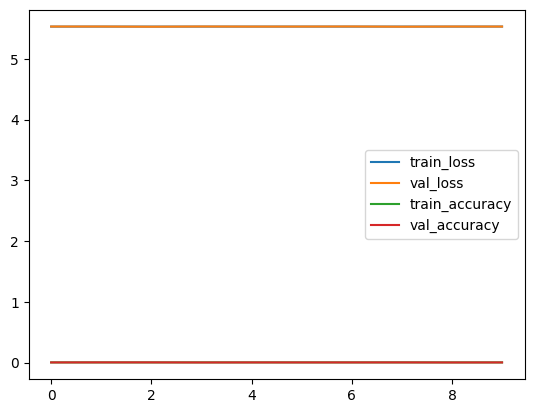

In [76]:
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()